In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
import glob
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [11]:
def add_month(df):
    new_index = [] 
    for i, index_value in enumerate(df.index):
        iteration = i % 12 + 1
        new_index.append(f'{index_value}-{iteration}')
    df.index = new_index

    return df

In [6]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
            i += 1
        return df

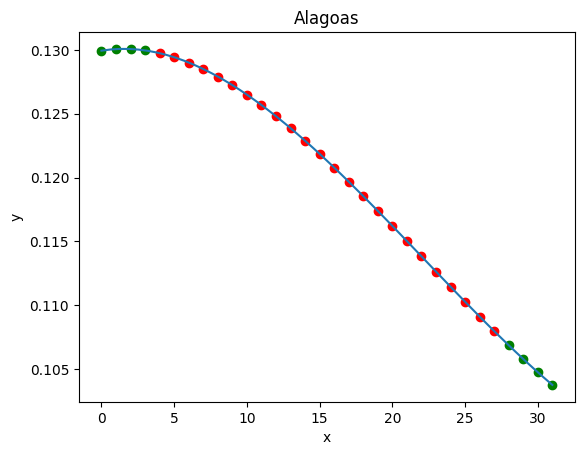

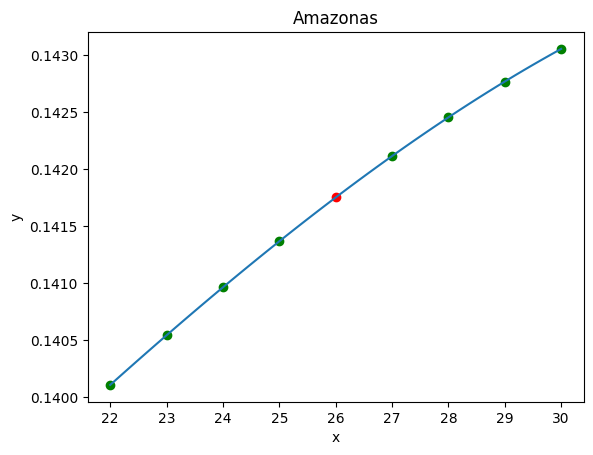

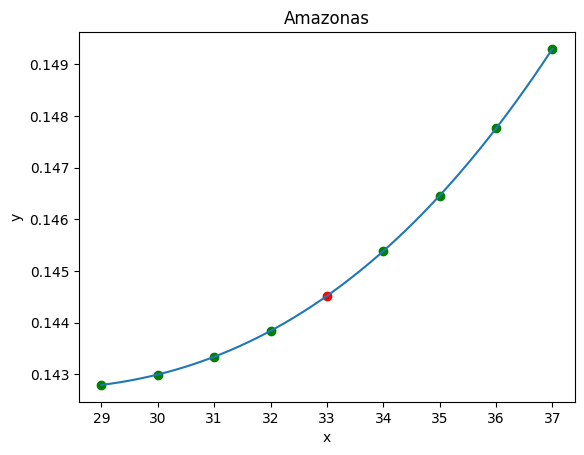

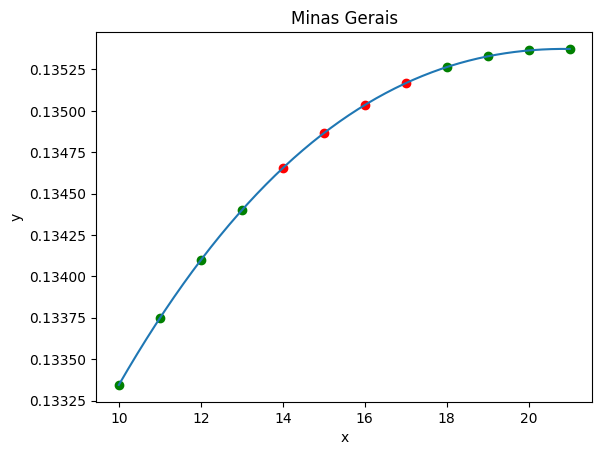

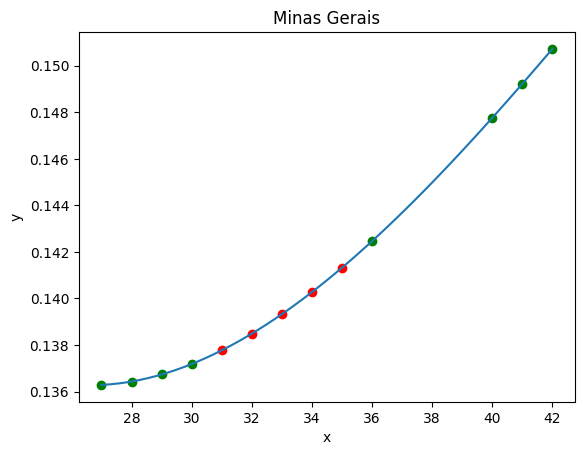

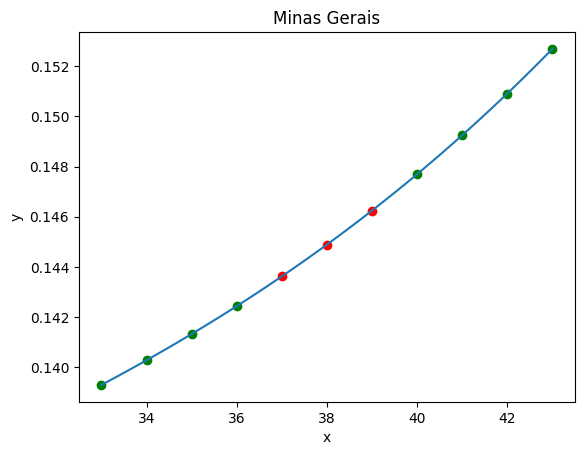

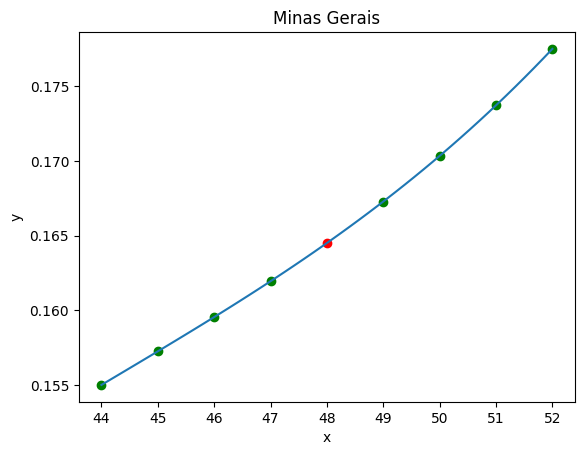

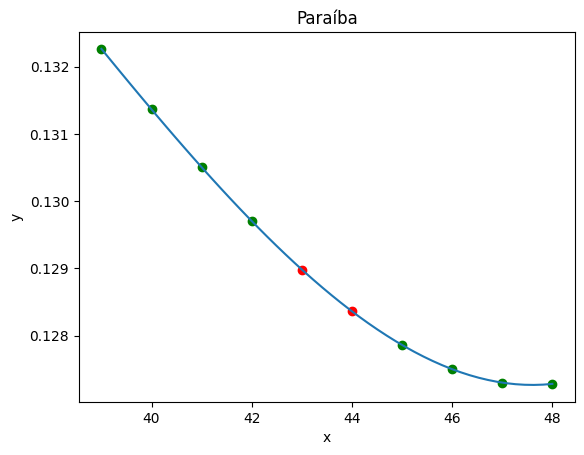

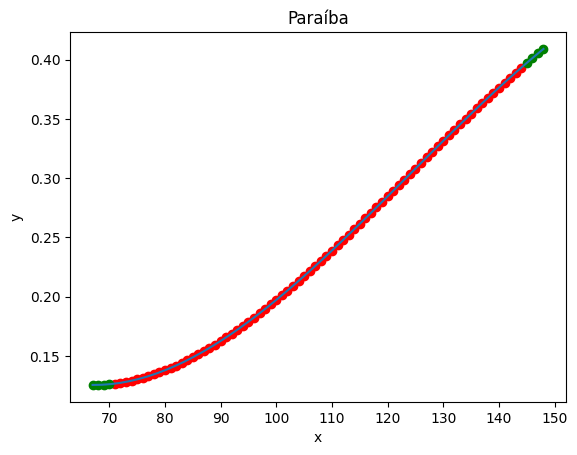

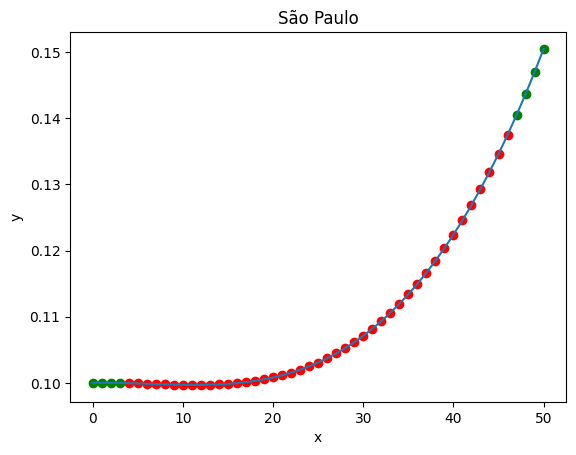

,Ano,Alagoas,Amazonas,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiais-03anhão,Minas Gerais,Mato Grosso do Sul,...,Pernambuco,Paraná,Rio de-01eiro,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Brasil,01
0,1995-01,0.130000,0.140800,0.124000,0.134400,0.101600,0.096800,0.104000,0.128571,0.093600,...,0.135200,0.134800,0.104400,0.106000,0.158400,0.113200,0.118400,0.100000,0.102000,0.118796
1,1995-02,0.130000,0.140415,0.124385,0.134785,0.101600,0.097185,0.104000,0.128571,0.093600,...,0.135200,0.134800,0.104400,0.105615,0.159169,0.113585,0.119169,0.100000,0.102385,0.119038
2,1995-03,0.130000,0.140431,0.125125,0.135155,0.101600,0.097555,0.104370,0.128137,0.093600,...,0.135200,0.135170,0.104770,0.105615,0.159540,0.113955,0.119910,0.100000,0.102755,0.119283
3,1995-04,0.130000,0.140061,0.125125,0.135512,0.101600,0.097912,0.104370,0.128137,0.093600,...,0.135200,0.135528,0.105128,0.105615,0.160254,0.114312,0.120624,0.100000,0.102755,0.119490
4,1995-05,0.129738,0.140061,0.124781,0.135857,0.101945,0.098257,0.104370,0.128937,0.093600,...,0.135200,0.135872,0.105472,0.105615,0.160599,0.114657,0.121314,0.099954,0.102410,0.119714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2022-08,0.587645,0.746275,0.597113,0.535686,0.529279,0.505935,0.520178,0.622619,0.523445,...,0.478890,0.549782,0.559828,0.581560,0.832392,0.663849,0.557749,0.590649,0.595809,0.598524
332,2022-09,0.587084,0.746582,0.596178,0.533990,0.527896,0.504835,0.518515,0.621866,0.521590,...,0.478683,0.546864,0.558289,0.579849,0.829742,0.663153,0.556659,0.588569,0.594029,0.597167
333,2022-10,0.585891,0.745406,0.594662,0.530449,0.526069,0.502971,0.516447,0.620866,0.518616,...,0.476012,0.544541,0.556367,0.577718,0.826925,0.661797,0.555237,0.585196,0.591914,0.595110
334,2022-11,0.584366,0.742703,0.592436,0.526253,0.523943,0.500670,0.513912,0.619585,0.515040,...,0.473486,0.540629,0.554021,0.575950,0.823550,0.660090,0.553445,0.581094,0.589755,0.592543


In [7]:
df = read_csv_replace_missing_by_polynomial("valor_cimento_portland_32.csv", 0, 0)
df

In [8]:
for idx, column in enumerate(df.columns):
    if idx > 0:
        df.rename(columns={column: f'{column} - value'}, inplace=True)
df

,Ano,Alagoas - value,Amazonas - value,Bahia - value,Ceará - value,Distrito Federal - value,Espírito Santo - value,Goiais-03anhão - value,Minas Gerais - value,Mato Grosso do Sul - value,...,Pernambuco - value,Paraná - value,Rio de-01eiro - value,Roraima - value,Rio Grande do Sul - value,Santa Catarina - value,Sergipe - value,São Paulo - value,Brasil - value,01 - value
0,1995-01,0.130000,0.140800,0.124000,0.134400,0.101600,0.096800,0.104000,0.128571,0.093600,...,0.135200,0.134800,0.104400,0.106000,0.158400,0.113200,0.118400,0.100000,0.102000,0.118796
1,1995-02,0.130000,0.140415,0.124385,0.134785,0.101600,0.097185,0.104000,0.128571,0.093600,...,0.135200,0.134800,0.104400,0.105615,0.159169,0.113585,0.119169,0.100000,0.102385,0.119038
2,1995-03,0.130000,0.140431,0.125125,0.135155,0.101600,0.097555,0.104370,0.128137,0.093600,...,0.135200,0.135170,0.104770,0.105615,0.159540,0.113955,0.119910,0.100000,0.102755,0.119283
3,1995-04,0.130000,0.140061,0.125125,0.135512,0.101600,0.097912,0.104370,0.128137,0.093600,...,0.135200,0.135528,0.105128,0.105615,0.160254,0.114312,0.120624,0.100000,0.102755,0.119490
4,1995-05,0.129738,0.140061,0.124781,0.135857,0.101945,0.098257,0.104370,0.128937,0.093600,...,0.135200,0.135872,0.105472,0.105615,0.160599,0.114657,0.121314,0.099954,0.102410,0.119714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2022-08,0.587645,0.746275,0.597113,0.535686,0.529279,0.505935,0.520178,0.622619,0.523445,...,0.478890,0.549782,0.559828,0.581560,0.832392,0.663849,0.557749,0.590649,0.595809,0.598524
332,2022-09,0.587084,0.746582,0.596178,0.533990,0.527896,0.504835,0.518515,0.621866,0.521590,...,0.478683,0.546864,0.558289,0.579849,0.829742,0.663153,0.556659,0.588569,0.594029,0.597167
333,2022-10,0.585891,0.745406,0.594662,0.530449,0.526069,0.502971,0.516447,0.620866,0.518616,...,0.476012,0.544541,0.556367,0.577718,0.826925,0.661797,0.555237,0.585196,0.591914,0.595110
334,2022-11,0.584366,0.742703,0.592436,0.526253,0.523943,0.500670,0.513912,0.619585,0.515040,...,0.473486,0.540629,0.554021,0.575950,0.823550,0.660090,0.553445,0.581094,0.589755,0.592543


In [12]:
df_month = df.copy()
df_month['Ano'] = df_month['Ano'].str[:4]
df_month = df_month.set_index('Ano', inplace=False)
df_month.index = df_month.index.astype(int)
df_2003 = df_month[df_month.index >= 2003] 
df_2003 = add_month(df_2003)
df_2003

,Alagoas - value,Amazonas - value,Bahia - value,Ceará - value,Distrito Federal - value,Espírito Santo - value,Goiais-03anhão - value,Minas Gerais - value,Mato Grosso do Sul - value,Mato Grosso - value,...,Pernambuco - value,Paraná - value,Rio de-01eiro - value,Roraima - value,Rio Grande do Sul - value,Santa Catarina - value,Sergipe - value,São Paulo - value,Brasil - value,01 - value
2003-1,0.294434,0.330279,0.299858,0.301376,0.254227,0.268445,0.260097,0.334536,0.282837,0.331800,...,0.297418,0.300568,0.291137,0.294583,0.399576,0.311113,0.339447,0.314974,0.309921,0.306129
2003-2,0.296211,0.331137,0.301903,0.301393,0.252655,0.270512,0.258964,0.335670,0.284487,0.333615,...,0.298912,0.301710,0.293538,0.296505,0.398811,0.312787,0.341257,0.317328,0.311566,0.307252
2003-3,0.297521,0.331306,0.303709,0.301309,0.250972,0.271941,0.257352,0.336553,0.285379,0.334864,...,0.300346,0.302645,0.295914,0.298178,0.397898,0.314207,0.343016,0.319840,0.312816,0.308061
2003-4,0.298766,0.331791,0.305311,0.300917,0.249179,0.273321,0.255929,0.336531,0.286089,0.336048,...,0.301729,0.303413,0.298264,0.299598,0.397042,0.315571,0.344722,0.322104,0.313909,0.308737
2003-5,0.299945,0.332189,0.306860,0.300417,0.247070,0.274453,0.254109,0.336406,0.286122,0.336447,...,0.302368,0.304034,0.300588,0.300965,0.396050,0.316880,0.346174,0.324320,0.314770,0.309179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-8,0.587645,0.746275,0.597113,0.535686,0.529279,0.505935,0.520178,0.622619,0.523445,0.600607,...,0.478890,0.549782,0.559828,0.581560,0.832392,0.663849,0.557749,0.590649,0.595809,0.598524
2022-9,0.587084,0.746582,0.596178,0.533990,0.527896,0.504835,0.518515,0.621866,0.521590,0.598965,...,0.478683,0.546864,0.558289,0.579849,0.829742,0.663153,0.556659,0.588569,0.594029,0.597167
2022-10,0.585891,0.745406,0.594662,0.530449,0.526069,0.502971,0.516447,0.620866,0.518616,0.596866,...,0.476012,0.544541,0.556367,0.577718,0.826925,0.661797,0.555237,0.585196,0.591914,0.595110
2022-11,0.584366,0.742703,0.592436,0.526253,0.523943,0.500670,0.513912,0.619585,0.515040,0.594246,...,0.473486,0.540629,0.554021,0.575950,0.823550,0.660090,0.553445,0.581094,0.589755,0.592543


In [13]:
for column in df_2003.columns:
    file_name = f"2003_mo_val_cim_{column}.csv"
    column_df = df_2003[[column]]
    column_df.to_csv(file_name, index=True)

In [8]:
df['Ano'] = df['Ano'].str.extract(r'(\d{4})').astype('int')
df_year = df.groupby(df['Ano']).sum()
df_year.columns = df_year.columns + " - Valor Cimento Portland"
df_year

,Alagoas - Valor Cimento Portland,Amazonas - Valor Cimento Portland,Bahia - Valor Cimento Portland,Ceará - Valor Cimento Portland,Distrito Federal - Valor Cimento Portland,Espírito Santo - Valor Cimento Portland,Goiais-03anhão - Valor Cimento Portland,Minas Gerais - Valor Cimento Portland,Mato Grosso do Sul - Valor Cimento Portland,Mato Grosso - Valor Cimento Portland,...,Pernambuco - Valor Cimento Portland,Paraná - Valor Cimento Portland,Rio de-01eiro - Valor Cimento Portland,Roraima - Valor Cimento Portland,Rio Grande do Sul - Valor Cimento Portland,Santa Catarina - Valor Cimento Portland,Sergipe - Valor Cimento Portland,São Paulo - Valor Cimento Portland,Brasil - Valor Cimento Portland,01 - Valor Cimento Portland
Ano,,,,,,,,,,,,,,,,,,,,,
1995,1.543973,1.679279,1.482716,1.624932,1.232828,1.183681,1.254647,1.566407,1.132292,1.435177,...,1.599733,1.626182,1.273585,1.268618,1.940552,1.389857,1.466443,1.198451,1.225354,1.437494
1996,1.427533,1.675985,1.408814,1.536578,1.321993,1.262666,1.336375,1.620324,1.238766,1.512805,...,1.485602,1.527349,1.348730,1.320607,2.018432,1.483415,1.573515,1.205408,1.291084,1.468121
1997,1.286587,1.717955,1.354617,1.452815,1.447035,1.366278,1.448196,1.650188,1.323405,1.645847,...,1.433232,1.445148,1.455453,1.442653,2.095000,1.606030,1.713195,1.285732,1.409650,1.521439
1998,1.443710,1.877427,1.491099,1.543225,1.667446,1.555114,1.690338,1.811529,1.494518,1.879749,...,1.528846,1.554716,1.646238,1.632717,2.302899,1.841488,1.976022,1.518001,1.607550,1.685779
1999,1.733985,2.243825,1.822143,1.840214,1.974197,1.857106,2.025188,2.199985,1.818193,2.184935,...,1.815929,1.883324,1.924758,1.900488,2.711214,2.149647,2.344852,1.964009,1.928466,1.995655
2000,2.198374,2.768381,2.251166,2.327306,2.317636,2.210587,2.363850,2.664250,2.196618,2.545715,...,2.280613,2.356991,2.254343,2.278213,3.293804,2.514289,2.752232,2.418183,2.350008,2.421327
2001,2.780406,3.391557,2.789593,2.955886,2.771130,2.622677,2.801196,3.299500,2.684911,3.098317,...,2.833460,2.909372,2.705677,2.783974,4.065188,3.007770,3.281904,2.927865,2.911182,2.975329
2002,3.316873,3.812096,3.349858,3.471555,3.045986,3.029122,3.093081,3.812766,3.173083,3.719886,...,3.348042,3.402467,3.222023,3.290580,4.644038,3.506746,3.820978,3.495851,3.468162,3.475886
2003,3.609987,3.993873,3.692839,3.580301,2.918132,3.282770,3.006392,4.008152,3.399873,4.031463,...,3.627100,3.647166,3.641734,3.596068,4.719016,3.814993,4.173873,3.922845,3.744805,3.700604


In [10]:
df_year.index = df_year.index.astype(int)
df_2003 = df_year[df_year.index >= 2003] 
for column in df_2003.columns:
    file_name = f"2003_01_valor_cim_{column}.csv"
    column_df = df_2003[[column]]
    column_df.to_csv(file_name, index=True)

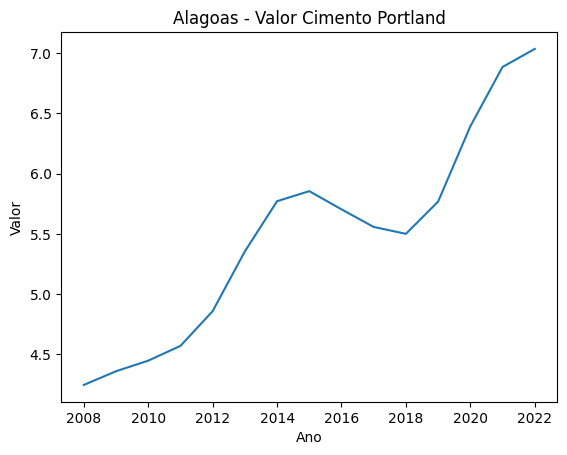

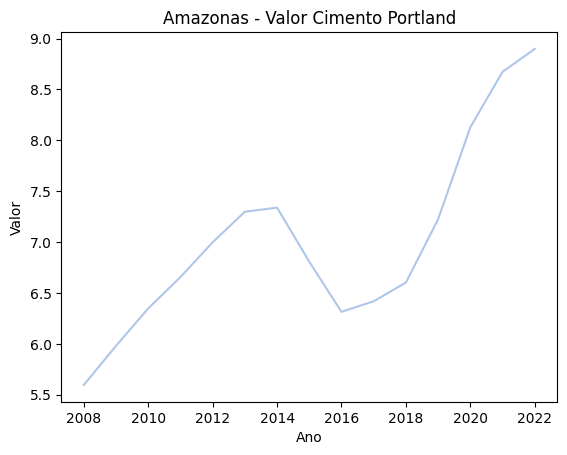

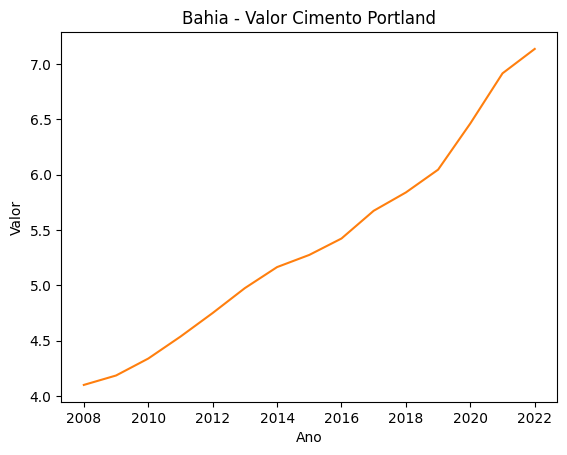

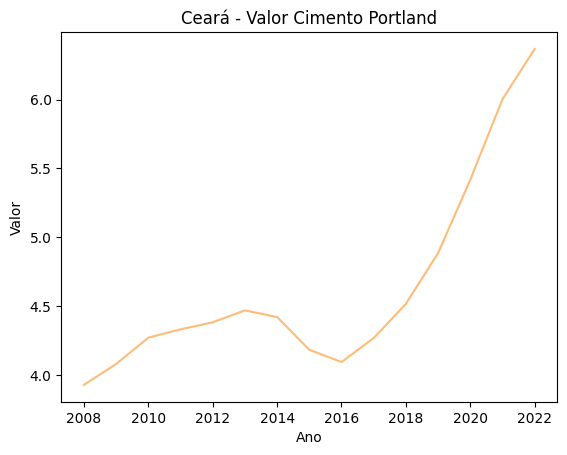

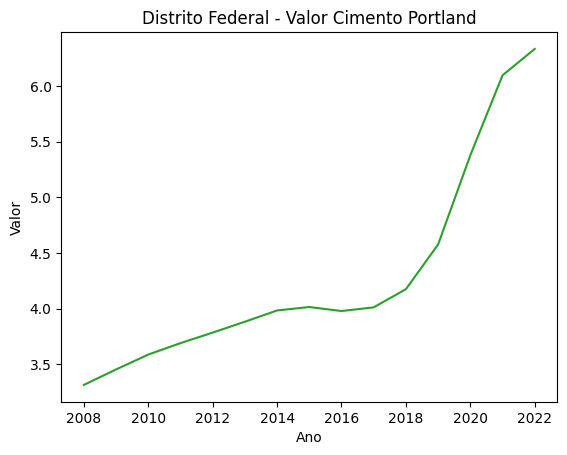

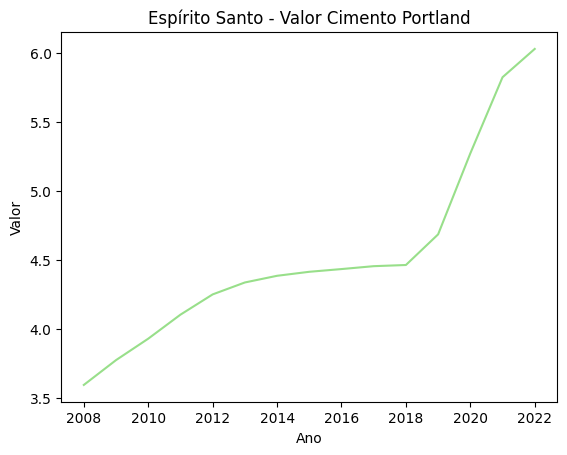

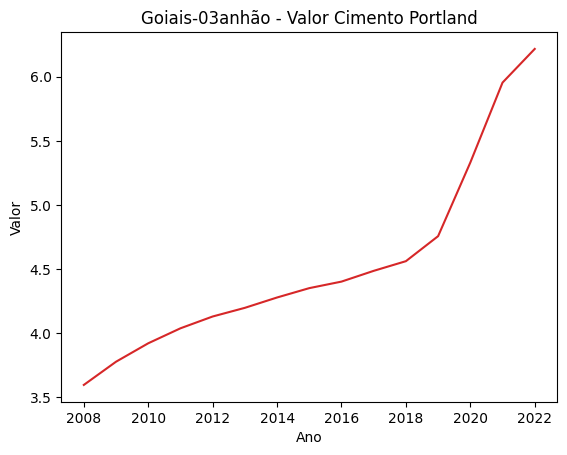

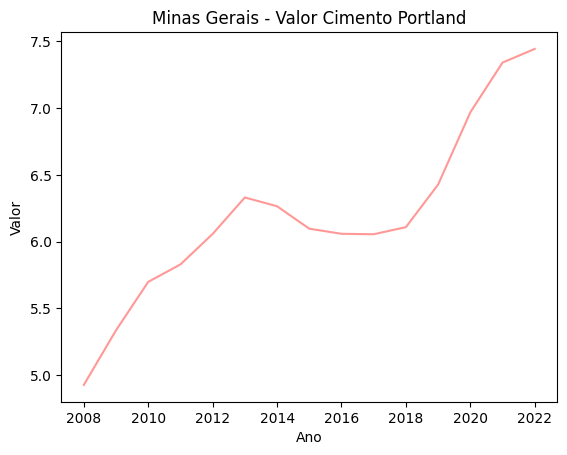

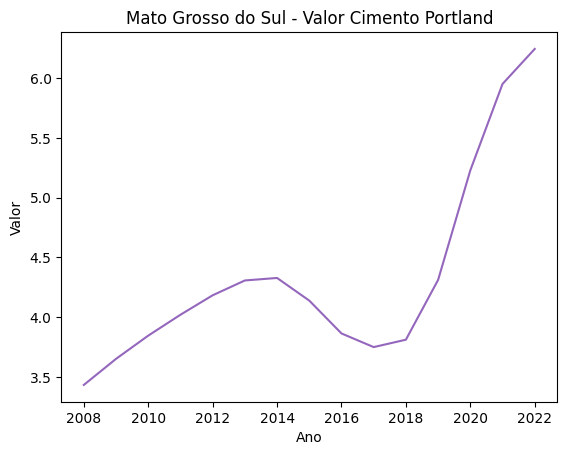

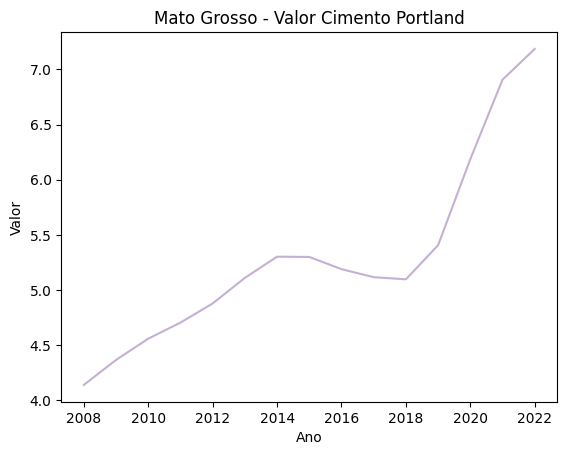

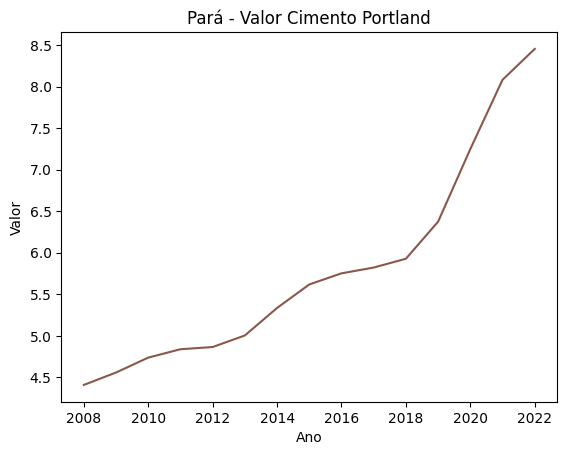

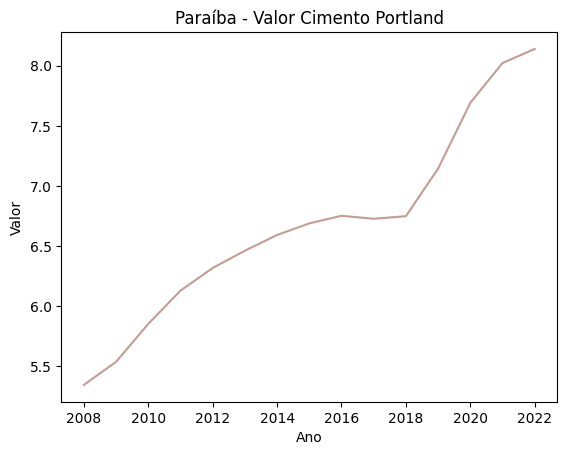

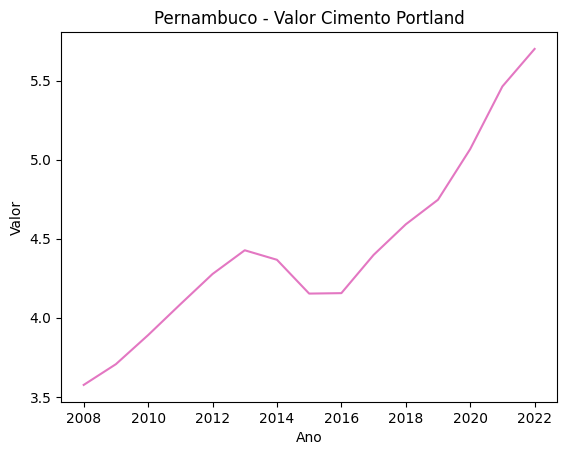

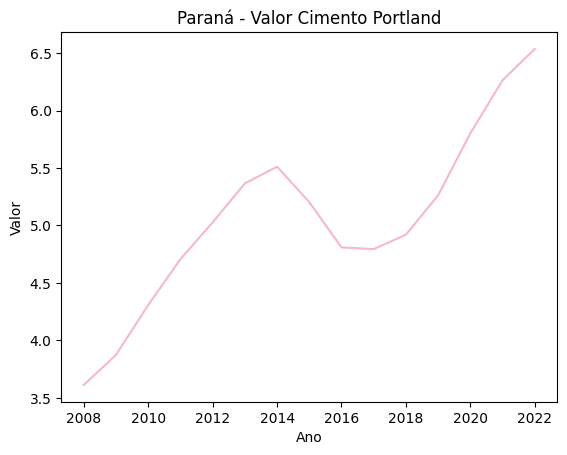

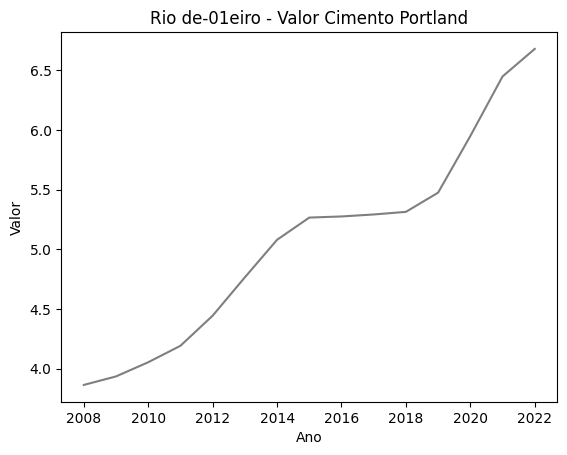

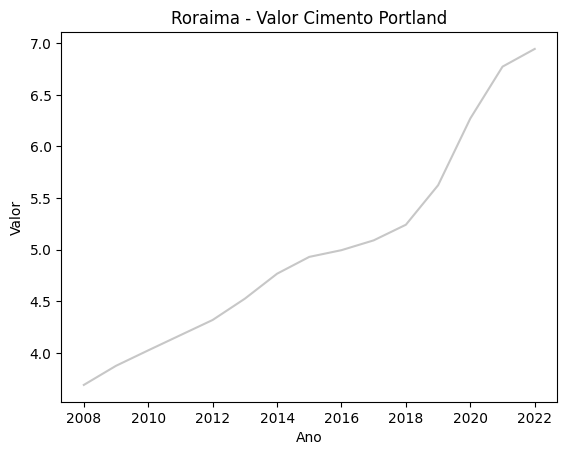

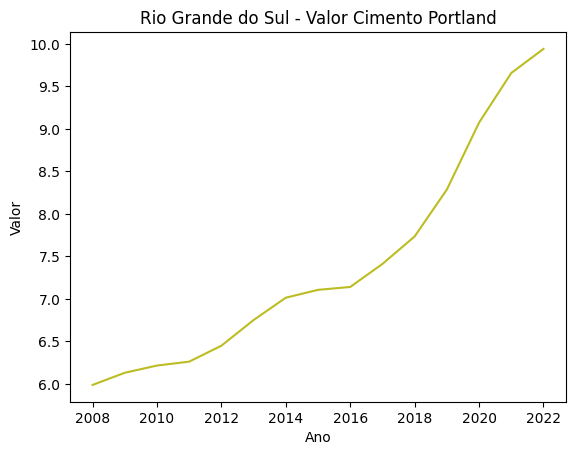

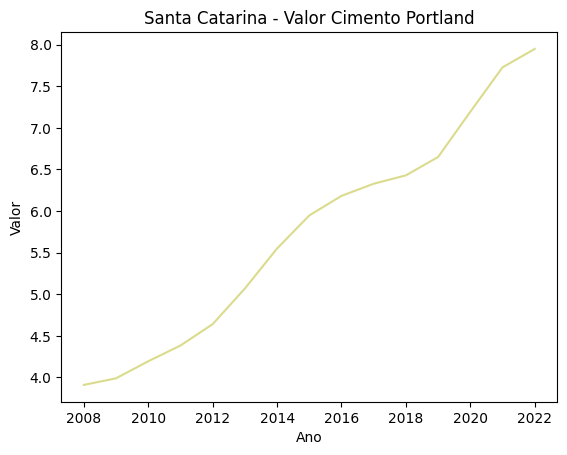

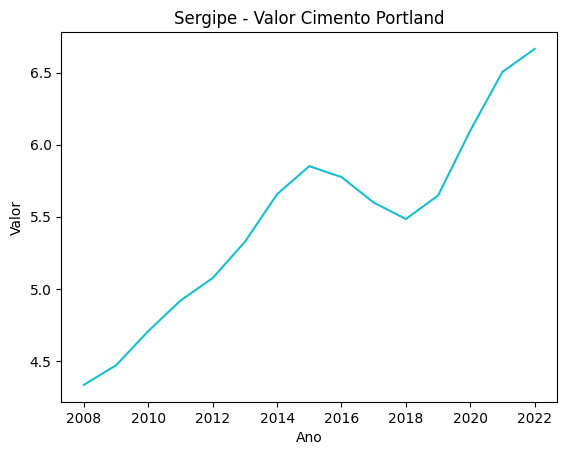

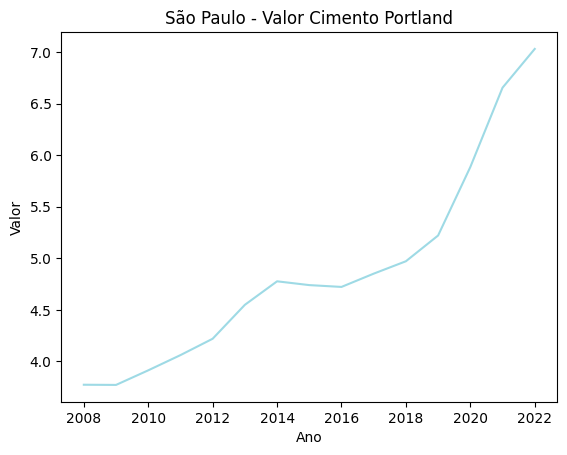

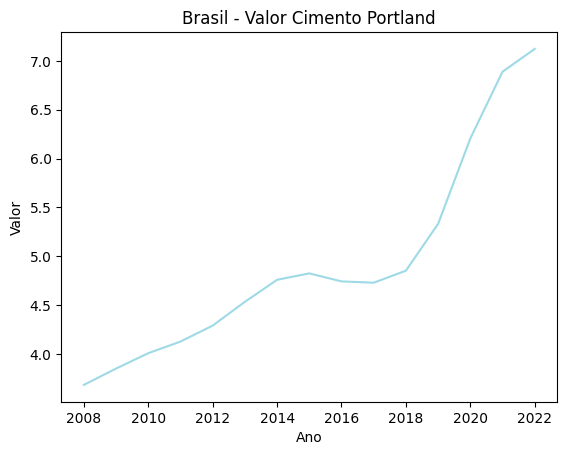

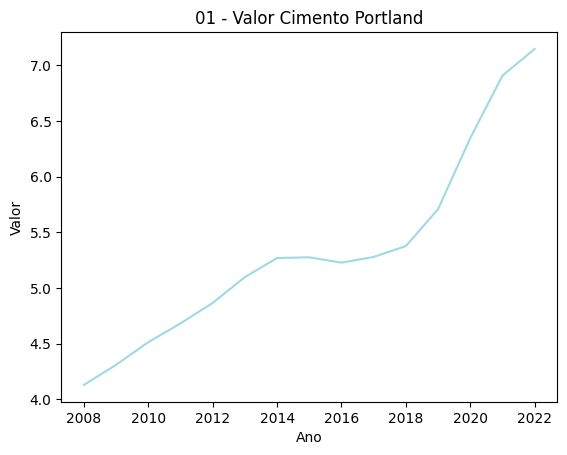

,Alagoas - Valor Cimento Portland,Amazonas - Valor Cimento Portland,Bahia - Valor Cimento Portland,Ceará - Valor Cimento Portland,Distrito Federal - Valor Cimento Portland,Espírito Santo - Valor Cimento Portland,Goiais-03anhão - Valor Cimento Portland,Minas Gerais - Valor Cimento Portland,Mato Grosso do Sul - Valor Cimento Portland,Mato Grosso - Valor Cimento Portland,...,Pernambuco - Valor Cimento Portland,Paraná - Valor Cimento Portland,Rio de-01eiro - Valor Cimento Portland,Roraima - Valor Cimento Portland,Rio Grande do Sul - Valor Cimento Portland,Santa Catarina - Valor Cimento Portland,Sergipe - Valor Cimento Portland,São Paulo - Valor Cimento Portland,Brasil - Valor Cimento Portland,01 - Valor Cimento Portland
Ano,,,,,,,,,,,,,,,,,,,,,
2008,4.245857,5.596891,4.100371,3.929539,3.314194,3.594891,3.597718,4.927101,3.433682,4.140784,...,3.575368,3.612886,3.862900,3.689138,5.988218,3.909333,4.333995,3.773615,3.682675,4.129157
2009,4.359552,5.981096,4.185427,4.081058,3.453013,3.774692,3.778583,5.336230,3.651735,4.367145,...,3.706614,3.874729,3.934097,3.874501,6.131171,3.988731,4.469789,3.771810,3.849951,4.309180
2010,4.447406,6.348653,4.338533,4.272214,3.586780,3.930070,3.922305,5.698825,3.846003,4.559665,...,3.890411,4.308613,4.053038,4.024163,6.216180,4.193595,4.706852,3.913291,4.007387,4.512244
2011,4.569912,6.656378,4.536829,4.332790,3.689511,4.104068,4.039003,5.829404,4.020724,4.705270,...,4.085239,4.707700,4.190909,4.171630,6.262114,4.383085,4.918522,4.060906,4.126192,4.681141
2012,4.858512,6.998333,4.749958,4.383851,3.784276,4.250916,4.131063,6.057729,4.183487,4.879101,...,4.276735,5.027391,4.443161,4.318665,6.449831,4.639898,5.074864,4.219677,4.289594,4.865188
2013,5.354694,7.298680,4.974973,4.470377,3.881855,4.337394,4.198572,6.330745,4.307498,5.110700,...,4.426819,5.366432,4.764618,4.525009,6.751488,5.068411,5.325730,4.548610,4.532924,5.096387
2014,5.771608,7.338802,5.164989,4.422096,3.983174,4.385795,4.279225,6.264774,4.328378,5.303015,...,4.366663,5.511210,5.079145,4.766966,7.014510,5.549438,5.656290,4.776666,4.758543,5.268585
2015,5.854960,6.807208,5.274929,4.184844,4.013984,4.414793,4.352142,6.096807,4.138994,5.300308,...,4.152923,5.203234,5.265287,4.930066,7.106564,5.947098,5.850928,4.739904,4.824331,5.274384
2016,5.704008,6.315193,5.423252,4.095297,3.978018,4.434544,4.403032,6.058653,3.864233,5.189897,...,4.155704,4.809593,5.274681,4.995251,7.140608,6.182664,5.775265,4.722216,4.742285,5.226964


In [14]:
df_2008 = df_year[df_year.index >= 2008]
plot_columns(df_2008)
df_2008

In [15]:
for column in df_2008.columns:
    file_name = f"2008_01_valor_cim_{column}.csv"
    column_df = df_2008[[column]]
    column_df.to_csv(file_name, index=True)